In [1]:
import torch
from torch.utils.data import DataLoader

import json
import numpy as np
from models import UTAE
from dataset import RwandaFieldsTrainSet

from utils.metrics import DiceScore,IoUScore,MicroScores
from skimage.measure import label

import matplotlib.pyplot as plt
from skimage.morphology import skeletonize,binary_dilation,binary_closing

from tqdm.notebook import tqdm

from utils.test_utils import *

from skimage.feature import peak_local_max


In [2]:
import logging



In [3]:
model_path = './results_unet3d_new/nasa_rfb_UNET3D_tu-tf_efficientnet_b1_300epochs_fold0_V2'
model_id = model_path.split('/')[-1]
model,cfg = load_trained_model(model_path)
model.cuda()

Unet3D(
  (encoder): TimmUniversalEncoder(
    (model): EfficientNetFeatures(
      (conv_stem): Conv2dSame(4, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (act1): SiLU(inplace=True)
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (act1): SiLU(inplace=True)
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): SiLU(inplace=True)
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
         

In [4]:
data_cfg = cfg['dataset']

if 'resize' not in data_cfg.keys():
    data_cfg['resize'] = None
#aug_tfm =  None if 'test_tfm' not in cfg.keys() else cfg['test_tfm']
dataset = RwandaFieldsTrainSet(**data_cfg,train=False,aug_tfm=None)



In [5]:
def plot(imgs,y_pred,mask):
    
    logger = logging.getLogger()
    old_level = logger.level
    logger.setLevel(100)
    
    imgs = imgs[0].cpu()
    y_pred = y_pred[0,0].cpu().detach()
    mask = mask[0,0].cpu()

    fig,axs = plt.subplots(2,4,figsize = (40,20))
    B,C,H,W = imgs.shape
    for i in range(B):
        img = imgs[i,...].cpu().numpy()        
        img = img.transpose(1,2,0)
        row,col = i // 4, i%4
        
        img = img *2.5
        img = (img + 1)/ 2

        rgb = img[:,:,[2,1,0]]
        axs[row,col].imshow(rgb)

    axs[1,2].imshow(y_pred)
    axs[1,3].imshow(mask)
    
    logger.setLevel(old_level)

def remove_noise_from_mask(y_pred,thresh,remove_noise):
    if remove_noise > 0:
        pred_hard = (y_pred >= thresh).float().cpu().numpy()[0,0]
        
        washed = label(pred_hard>0,background=0,connectivity=2)
        washed = noise_filter(washed,mina=remove_noise)
        pred_hard = (washed > 0)[np.newaxis,np.newaxis,:,:]
        y_pred = torch.from_numpy(pred_hard).float().cuda()
    
    return y_pred

# resize = [256] -- padsize = [320] -- thresh = 0.5
macro_f1 :: 45.308
macro_iou :: 29.289



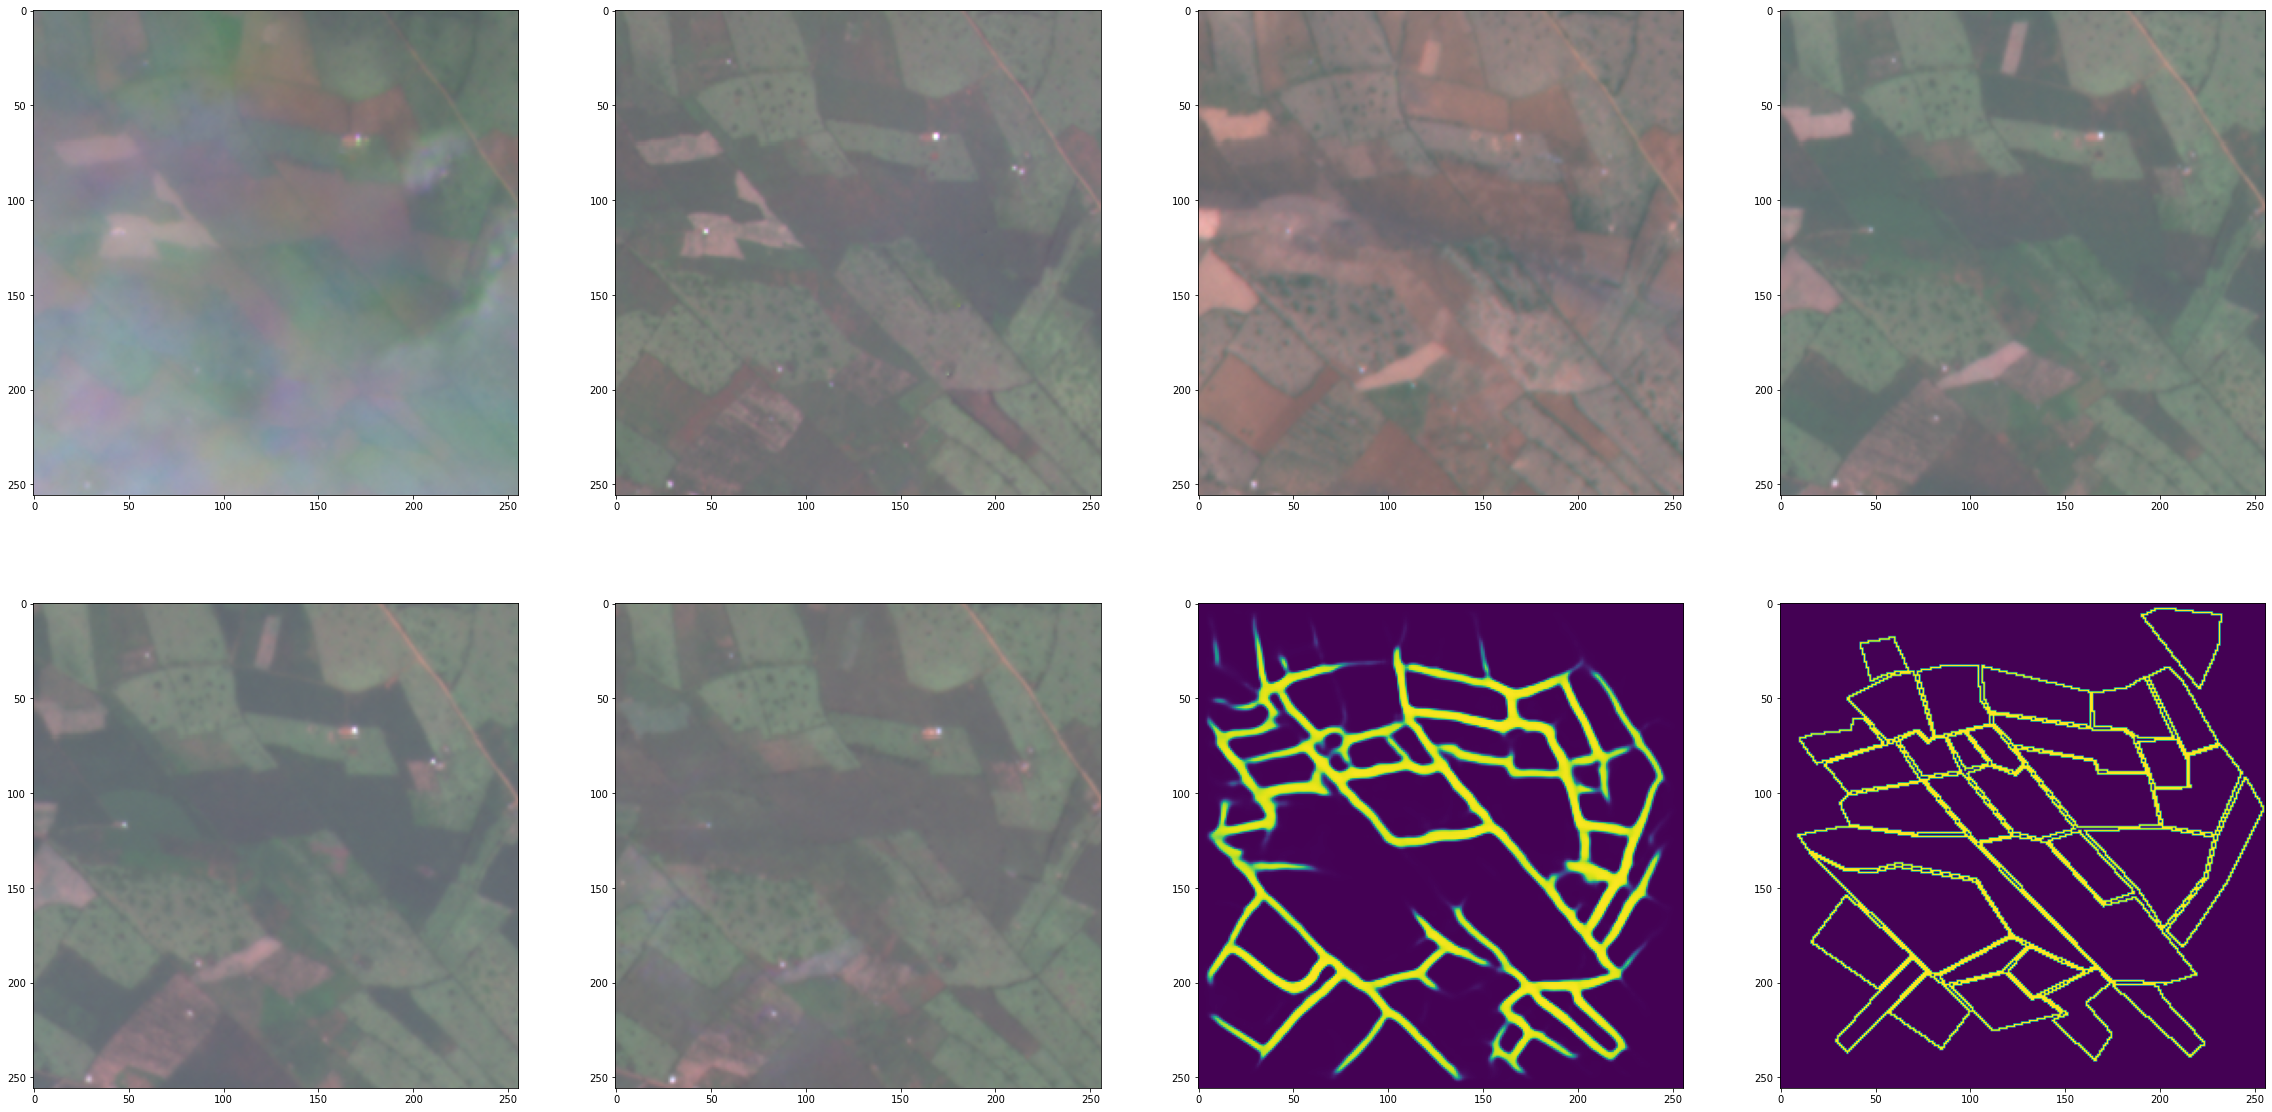

In [7]:

IDX = 9
TTA = False

remove_noise = 0
apply_closing = False
thresh = 0.5

resize_sizes = [256]
pad_sizes = [320]

thresh = 0.5

dice_scorer = DiceScore(threshold=0.5)
iou_scorer = IoUScore(threshold=0.5)


ret = dataset.__getitem__(IDX)
imgs,mask,cb_mask,dates =ret['x'],ret['y_gt'],ret['cb_mask'],ret['dates']

imgs = imgs.unsqueeze(0)
mask = mask.cuda().unsqueeze(0)
x = imgs.clone().cuda()

preds = []
for i in range(len(resize_sizes)):
    resize = resize_sizes[i]
    padsize = pad_sizes[i]
    
    x = imgs.clone().cuda()
    y_pred = run(x,model,padsize,resize,TTA)

    preds.append(y_pred)

if len(preds) > 1:
    y_pred = torch.cat(preds,dim=0)
    y_pred = y_pred.mean(dim=0).unsqueeze(0)

if apply_closing:
    pred_hard = (y_pred >= thresh).float().cpu().numpy()[0,0]
    pred_hard = binary_closing(pred_hard,footprint=np.ones((3,3)))[np.newaxis,np.newaxis,:,:]
    y_pred = torch.from_numpy(pred_hard).float().cuda()



y_pred = remove_noise_from_mask(y_pred,thresh,remove_noise)
dice_score = dice_scorer(y_pred,mask)
iou_score = iou_scorer(y_pred,mask)


scores = {
    'macro_f1': dice_score,
    'macro_iou': iou_score,
    }

out_msg = f'# resize = {resize_sizes} -- padsize = {pad_sizes} -- thresh = {thresh}\n'
for k,v in scores.items():
    out_msg += f'{k} :: {v*100:.5}\n'

pred_hard = y_pred >= thresh

plot(imgs,y_pred,mask)
print(out_msg)
plt.show()



In [28]:
loader = DataLoader(dataset=dataset,batch_size=1,num_workers=4)
final_msg = ''

In [121]:
loader = tqdm(loader)

TTA = True
remove_noise = 10
thresh = 0.5


resize_sizes = [256]
pad_sizes = [320]

dice_scorer = DiceScore(threshold=thresh)
iou_scorer = IoUScore(threshold=thresh)
micro_scorer = MicroScores(threshold=thresh)

for ret in loader:

    imgs,mask,cb_mask,dates =ret['x'],ret['y_gt'],ret['cb_mask'],ret['dates']
    imgs = imgs
    mask = mask.cuda()

    preds = []
    for i in range(len(resize_sizes)):
        resize = resize_sizes[i]
        padsize = pad_sizes[i]
        
        x = imgs.clone().cuda()
        y_pred = run(x,model,padsize,resize,TTA)

        preds.append(y_pred)


    if len(preds) > 1:
        y_pred = torch.cat(preds,dim=0)
        y_pred = y_pred.mean(dim=0).unsqueeze(0)

    if apply_closing:
        pred_hard = (y_pred >= thresh).float().cpu().numpy()[0,0]
        pred_hard = binary_closing(pred_hard,footprint=np.ones((3,3)))[np.newaxis,np.newaxis,:,:]
        y_pred = torch.from_numpy(pred_hard).float().cuda()

    if remove_noise > 0:
        pred_hard = (y_pred >= thresh).float().cpu().numpy()[0,0]
        
        washed = label(pred_hard>0,background=0,connectivity=2)
        washed = noise_filter(washed,mina=remove_noise)
        pred_hard = (washed > 0)[np.newaxis,np.newaxis,:,:]
        y_pred = torch.from_numpy(pred_hard).float().cuda()

    dice_score = dice_scorer(y_pred,mask)
    iou_score = iou_scorer(y_pred,mask)
    micro_scores = micro_scorer(y_pred,mask)

scores = {
    'macro_f1': dice_score,
    'macro_iou': iou_score,
    'micro_f1': micro_scores['f1'],
    'micro_iou': micro_scores['iou'],
    'micro_precision': micro_scores['precision'],
    'micro_recall': micro_scores['recall'],

    }

out_msg = f'# resize = {resize_sizes} -- padsize = {pad_sizes} -- thresh = {thresh} -- remove_noise = {remove_noise} -CLOSING\n'
for k,v in scores.items():
    out_msg += f'{k} :: {v*100:.5}\n'
out_msg+='\n'
final_msg+=out_msg
print(out_msg)

  0%|          | 0/15 [00:00<?, ?it/s]

# resize = [224, 256] -- padsize = [288, 320] -- thresh = 0.5 -- remove_noise = 10 -CLOSING
macro_f1 :: 37.678
macro_iou :: 23.676
micro_f1 :: 42.461
micro_iou :: 26.952
micro_precision :: 34.23
micro_recall :: 55.902




In [122]:
print(final_msg)

# resize = [256] -- padsize = [None]
macro_f1 :: 33.956
macro_iou :: 20.915
micro_f1 :: 38.616
micro_iou :: 23.928
micro_precision :: 27.696
micro_recall :: 63.752

# resize = [256] -- padsize = [288]
macro_f1 :: 36.514
macro_iou :: 22.894
micro_f1 :: 42.062
micro_iou :: 26.632
micro_precision :: 33.679
micro_recall :: 56.003

# resize = [256] -- padsize = [320]
macro_f1 :: 36.938
macro_iou :: 23.185
micro_f1 :: 42.191
micro_iou :: 26.736
micro_precision :: 33.959
micro_recall :: 55.694

# resize = [224] -- padsize = [None]
macro_f1 :: 33.259
macro_iou :: 20.37
micro_f1 :: 37.848
micro_iou :: 23.341
micro_precision :: 26.607
micro_recall :: 65.538

# resize = [224] -- padsize = [256]
macro_f1 :: 37.075
macro_iou :: 23.189
micro_f1 :: 42.056
micro_iou :: 26.627
micro_precision :: 33.395
micro_recall :: 56.783

# resize = [224] -- padsize = [288]
macro_f1 :: 37.685
macro_iou :: 23.592
micro_f1 :: 42.14
micro_iou :: 26.695
micro_precision :: 33.772
micro_recall :: 56.022

# resize = [224]